## AirBnB、ユーザが最初に訪れる国名の予測

Basic Course - Day2: Takao Ishikawa

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

C:\Users\takao\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
age_gender_data = pd.read_csv("Airbnb/age_gender_bkts.csv")
country_data = pd.read_csv("Airbnb/countries.csv")
# session_data = pd.read_csv("Airbnb/sessions.csv")
# smp_submission_data = pd.read_csv("Airbnb/sample_submission_NDF.csv")
test = pd.read_csv("Airbnb/test_users.csv")
train = pd.read_csv("Airbnb/train_users_2.csv")

## TrainとTestデータの結合

In [3]:
# 識別列を追加した上で、TrainとTestデータを結合
test["country_destination"] = np.nan
test["source"] = "test"
train["source"] = "train"
whole = pd.concat([train, test], axis=0)
whole.shape

(275547, 17)

In [4]:
# 欠損値検査
whole.count()

id                         275547
date_account_created       275547
timestamp_first_active     275547
date_first_booking          88908
gender                     275547
age                        158681
signup_method              275547
signup_flow                275547
language                   275547
affiliate_channel          275547
affiliate_provider         275547
first_affiliate_tracked    269462
signup_app                 275547
first_device_type          275547
first_browser              275547
country_destination        213451
source                     275547
dtype: int64

In [5]:
# Genderの中身精査
whole.gender.value_counts()
  # genderがunknownのデータは全体の半分、これらは処理をせずに独立の変数として扱う
  # genderが"OTHER"のグループは334件と少ないので、unknownとして扱う方針とする（処理は別途）

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [6]:
# age_gender_dataとの結合に備えて、whole["gender"]のnotationを変更する
def change_gender_notation(x):
    if x == "FEMALE":
        return "female"
    elif x == "MALE":
        return "male"
    elif x == "OTHER":
        return "-unknown-"
    elif x == "-unknown-":
        return "-unknown-"

In [7]:
whole["gender"] = whole["gender"].apply(change_gender_notation)

In [8]:
# Ageのデータクリーニング
whole.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [9]:
# 明らかな異常値を、まずnullに置き換える。## 一連のnull置き換えを実施したのちに、medianで処理する方針
whole.loc[whole["age"] >= 2000, "age"]= np.nan
whole.loc[whole["age"] < 10, "age"] = np.nan

In [10]:
# 西暦年をageに入っているものは、2014から引き算をして、年齢を算出
whole[whole["age"] > 1900].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,source
41046,rm0p78riic,2012-09-15,20120915182743,2012-09-16,female,1949.0,facebook,12,en,api,other,untracked,Moweb,Windows Desktop,Chrome,US,train
55474,lxfw8qaa2e,2013-01-11,20130111014721,NaN,male,1931.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF,train
59537,lkgth08quo,2013-02-07,20130207231010,2013-02-08,male,1932.0,facebook,12,en,api,other,untracked,Moweb,iPhone,-unknown-,US,train
67223,n87aqj7mf0,2013-03-25,20130325205715,NaN,male,1932.0,facebook,12,en,api,other,untracked,Moweb,Windows Desktop,Chrome,NDF,train
67610,nc8fk6z69z,2013-03-27,20130327211209,2013-04-23,male,1932.0,facebook,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,US,train


In [11]:
# 1900を超えているものは、誕生年とみなして、2014年時点の年齢を計算
def age_correct(x):
    if x > 1900.0:
        y = 2014.0 - x
        return y
    else:
        return x

In [12]:
whole["age"] = whole["age"].apply(age_correct)

In [13]:
# ageの統計量を見て、最大値が適正かを確認 --- 上記の計算の結果 100歳を超える年齢が表出
whole.age.describe()

count    157865.000000
mean         36.895322
std          13.848966
min          15.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         150.000000
Name: age, dtype: float64

In [14]:
# （実際はいるかもしれないが）100歳を超える年齢は異常値とみなして、再びnanに置換
whole.loc[whole["age"] > 100, "age"] = np.nan

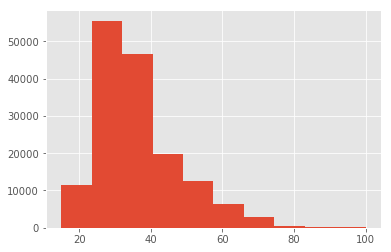

In [15]:
whole["age"].hist() #これで大丈夫そう

In [16]:
# ageのnullの数をカウント
sum(whole["age"].isnull())

119544

In [17]:
# ageのnullを中央値に変換  --- nullが119544件あるので、中央値で置き換えるのは戸惑うが、ほかに手がないので置換実行～
whole["age"] = whole["age"].fillna(whole.age.median())

In [18]:
print("whole records:", whole["age"].count(), "missing_records:", sum(whole["age"].isnull()))

whole records: 275547 missing_records: 0


## Age_gender_dataのデータ加工

In [19]:
age_gender_data.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [20]:
# yearのカラムは不要なので削除
age_gender_data = age_gender_data.drop('year', axis=1)

In [21]:
# population_in_thousandsを横持ちにするために、まずcountry_destinationをダミー変数に置換
age_gender_data = pd.get_dummies(data = age_gender_data, columns = ["country_destination"])
age_gender_data.head()

,age_bucket,gender,population_in_thousands,country_destination_AU,country_destination_CA,country_destination_DE,country_destination_ES,country_destination_FR,country_destination_GB,country_destination_IT,country_destination_NL,country_destination_PT,country_destination_US
0,100+,male,1.0,1,0,0,0,0,0,0,0,0,0
1,95-99,male,9.0,1,0,0,0,0,0,0,0,0,0
2,90-94,male,47.0,1,0,0,0,0,0,0,0,0,0
3,85-89,male,118.0,1,0,0,0,0,0,0,0,0,0
4,80-84,male,199.0,1,0,0,0,0,0,0,0,0,0


In [22]:
# Population_in_thousandsをダミー変数にかける
extract_cols = age_gender_data.columns[3:]

In [23]:
for col in extract_cols:
    age_gender_data[col] = age_gender_data[col] * age_gender_data['population_in_thousands']

In [24]:
# 無駄な行があるので、レコード集計を実施
age_gender_data = age_gender_data.groupby(["age_bucket", "gender"]).sum().reset_index()
age_gender_data.head()

,age_bucket,gender,population_in_thousands,country_destination_AU,country_destination_CA,country_destination_DE,country_destination_ES,country_destination_FR,country_destination_GB,country_destination_IT,country_destination_NL,country_destination_PT,country_destination_US
0,0-4,female,20861.0,781.0,991.0,1713.0,1198.0,1938.0,1888.0,1383.0,438.0,225.0,10306.0
1,0-4,male,21925.0,824.0,1045.0,1811.0,1272.0,2035.0,1981.0,1468.0,462.0,239.0,10788.0
2,10-14,female,20640.0,707.0,929.0,1800.0,1124.0,1894.0,1690.0,1388.0,493.0,269.0,10346.0
3,10-14,male,21604.0,743.0,983.0,1892.0,1189.0,1985.0,1771.0,1468.0,517.0,285.0,10771.0
4,100+,female,145.0,4.0,7.0,14.0,9.0,19.0,13.0,15.0,2.0,1.0,61.0


In [25]:
# gender -unknown- にぶつける行を作るため、genderのカラムをdropしたテーブルを作る
age_gender_data_mod = age_gender_data.drop('gender', axis=1)

In [26]:
# age_bucketのみでgroupbyを実行
age_gender_data_mod = age_gender_data_mod.groupby(["age_bucket"]).sum().reset_index()

In [27]:
# 作成したデータに、unknownの値を持つgender列を作成
age_gender_data_mod["gender"] = "-unknown-"

In [28]:
# female/male毎に集計した先ほどのデータにunionする
age_gender_data = pd.concat([age_gender_data, age_gender_data_mod], axis=0)   #[ ] を忘れないこと~ 

## wholeデータとage_gender_dataの結合

In [29]:
whole.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,source
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,33.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,train
1,820tgsjxq7,2011-05-25,20090523174809,NaN,male,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,train
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,female,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,train
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,female,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,train
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,train


In [30]:
set(age_gender_data["age_bucket"])

{'0-4',
 '10-14',
 '100+',
 '15-19',
 '20-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '5-9',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '70-74',
 '75-79',
 '80-84',
 '85-89',
 '90-94',
 '95-99'}

In [31]:
# age_genderデータのage_bucketは扱いづらいので、min値を取り出して、新しいカラムを作る
def get_left_num(x):
    x_len = len(x)
    if x_len ==3:
        return int(x[0])
    elif x_len == 5:
        return int(x[:2])
    elif x_len == 4:
        return int(x[:3]) + 1
    else:
        return 999

In [32]:
age_gender_data["age_min_key"] = age_gender_data["age_bucket"].apply(get_left_num)

In [33]:
age_gender_data.head()

,age_bucket,country_destination_AU,country_destination_CA,country_destination_DE,country_destination_ES,country_destination_FR,country_destination_GB,country_destination_IT,country_destination_NL,country_destination_PT,country_destination_US,gender,population_in_thousands,age_min_key
0,0-4,781.0,991.0,1713.0,1198.0,1938.0,1888.0,1383.0,438.0,225.0,10306.0,female,20861.0,0
1,0-4,824.0,1045.0,1811.0,1272.0,2035.0,1981.0,1468.0,462.0,239.0,10788.0,male,21925.0,0
2,10-14,707.0,929.0,1800.0,1124.0,1894.0,1690.0,1388.0,493.0,269.0,10346.0,female,20640.0,10
3,10-14,743.0,983.0,1892.0,1189.0,1985.0,1771.0,1468.0,517.0,285.0,10771.0,male,21604.0,10
4,100+,4.0,7.0,14.0,9.0,19.0,13.0,15.0,2.0,1.0,61.0,female,145.0,101


In [35]:
# 今度は、wholeに対して、age_min_keyを作成する
val_list = np.unique(age_gender_data["age_min_key"])  ##searchsortedの引数に、setが使えなかったので、np.uniqueを使った

In [36]:
arr = np.array(val_list)

In [37]:
whole["age_min_key"] = arr[arr.searchsorted(whole["age"])-1] 
# searchsortedはインデックスを返すので、arrの中の添え字にして値を取り出す

In [38]:
whole.head()
whole.shape

(275547, 18)

In [39]:
# genderと、上記で作成したage_min_keyを軸にして、age_gender_dataとwholeを結合
whole = pd.merge(whole, age_gender_data, on=['age_min_key', 'gender'], how='left')

In [40]:
whole.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,country_destination_CA,country_destination_DE,country_destination_ES,country_destination_FR,country_destination_GB,country_destination_IT,country_destination_NL,country_destination_PT,country_destination_US,population_in_thousands
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,33.0,facebook,0,en,direct,...,2502.0,5198.0,3394.0,4081.0,4302.0,3605.0,1000.0,733.0,21847.0,48408.0
1,820tgsjxq7,2011-05-25,20090523174809,NaN,male,38.0,facebook,0,en,seo,...,1189.0,2448.0,2117.0,1842.0,1979.0,2117.0,490.0,419.0,10329.0,23727.0
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,female,56.0,basic,3,en,direct,...,1305.0,2996.0,1531.0,2125.0,1991.0,2069.0,580.0,366.0,11264.0,24966.0
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,female,42.0,facebook,0,en,direct,...,1169.0,2559.0,1924.0,2231.0,2147.0,2411.0,583.0,418.0,10308.0,24588.0
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,2348.0,5192.0,3976.0,4443.0,4248.0,4839.0,1165.0,834.0,20467.0,49170.0


In [41]:
whole.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'source', 'age_min_key',
       'age_bucket', 'country_destination_AU', 'country_destination_CA',
       'country_destination_DE', 'country_destination_ES',
       'country_destination_FR', 'country_destination_GB',
       'country_destination_IT', 'country_destination_NL',
       'country_destination_PT', 'country_destination_US',
       'population_in_thousands'],
      dtype='object')

In [42]:
# country_destination_XXには、訪問者数が絶対値で入っているので、行当たりのトータルが100%になるように、population_in_thousandsで割る
tgt_countries = ['country_destination_AU', 'country_destination_CA','country_destination_DE', 
                 'country_destination_ES', 'country_destination_FR', 'country_destination_GB', 
                 'country_destination_IT', 'country_destination_NL','country_destination_PT', 'country_destination_US']

In [45]:
for col in tgt_countries:
    whole[col] = whole[col] / whole["population_in_thousands"]

In [47]:
# population_in_thousandsは役割を終えたので、dropする
whole = whole.drop('population_in_thousands', axis=1)

## ログデータは、利活用しないこととした
ログデータのうち、google_translateの起動有無を特徴量として抽出しようと考えたが、対象userが69人のみだったので実施せず

## Countryデータの整形・結合

In [48]:
country_data.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [49]:
# userの母国語が、行き先の国の言語とマッチしているかをフラグ化する。
# まずは、wholeとcountry_dataの中の言語のnotationの違いを補正
lan_conv = {
    'deu':'de',
    'eng':'en',
    'fra':'fr',
    'ita':'it',
    'nld':'nl',
    'por':'pt',
    'spa':'es'
}

In [50]:
country_data["language"] = country_data["destination_language "].map(lan_conv)

In [51]:
# wholeのテーブルに、それぞれのcountryのカラムを作り、値をその言語とする
country = np.array(country_data["country_destination"])
language = np.array(country_data["language"])

In [52]:
for i in range(len(country)):
    whole[country[i]] = language[i]

In [53]:
whole.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,33.0,facebook,0,en,direct,...,en,en,de,es,fr,en,it,nl,pt,en
1,820tgsjxq7,2011-05-25,20090523174809,NaN,male,38.0,facebook,0,en,seo,...,en,en,de,es,fr,en,it,nl,pt,en
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,female,56.0,basic,3,en,direct,...,en,en,de,es,fr,en,it,nl,pt,en
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,female,42.0,facebook,0,en,direct,...,en,en,de,es,fr,en,it,nl,pt,en
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,en,en,de,es,fr,en,it,nl,pt,en


In [54]:
whole.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'source', 'age_min_key',
       'age_bucket', 'country_destination_AU', 'country_destination_CA',
       'country_destination_DE', 'country_destination_ES',
       'country_destination_FR', 'country_destination_GB',
       'country_destination_IT', 'country_destination_NL',
       'country_destination_PT', 'country_destination_US', 'AU', 'CA', 'DE',
       'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US'],
      dtype='object')

In [55]:
# それぞれのcountryのカラムで、userの母国語とのマッチングをフラグ化する
lang_countries = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US']

In [56]:
for each_lan in lang_countries:
    whole[each_lan] = (whole["language"] == whole[each_lan]) * 1 

In [57]:
whole.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,33.0,facebook,0,en,direct,...,1,1,0,0,0,1,0,0,0,1
1,820tgsjxq7,2011-05-25,20090523174809,NaN,male,38.0,facebook,0,en,seo,...,1,1,0,0,0,1,0,0,0,1
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,female,56.0,basic,3,en,direct,...,1,1,0,0,0,1,0,0,0,1
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,female,42.0,facebook,0,en,direct,...,1,1,0,0,0,1,0,0,0,1
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,1,1,0,0,0,1,0,0,0,1


## 特徴量の量産プロセス（とりあえず、たくさん作ってみる）

In [58]:
#date_account_createdから年と月を抽出し特徴量に
whole["Month_account_created"]= whole['date_account_created'].apply(lambda x: int(x[5:7]))
whole["Year_account_created"]= whole['date_account_created'].apply(lambda x: int(x[:4]))

#timestamp_first_activeから年と月を抽出し特徴量に
whole.timestamp_first_active=whole.timestamp_first_active.apply(str)
whole["Month_first_active"]=whole['timestamp_first_active'].apply(lambda x:int(x[4:6]))
whole["Year_first_active"]=whole['timestamp_first_active'].apply(lambda x:int(x[:4]))

In [59]:
# gender,signup_method,language~first_browserについて
#カテゴリー変数なので数値に変換
category_columns=["gender","signup_method","language","affiliate_channel","affiliate_provider",
                  "first_affiliate_tracked","signup_app","first_device_type","first_browser"]
whole = pd.get_dummies(whole, columns=category_columns)

In [60]:
# auto_feature generation関数の使用に必要なライブラリをインポート
from scipy.stats import spearmanr
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error

In [63]:
# ターゲット変数と、割り算による特徴量生成の対象となるカラムを指定する
target_col = 'country_destination'
feature_cols = ['age', 'country_destination_CA',
       'country_destination_DE', 'country_destination_ES',
       'country_destination_FR', 'country_destination_GB',
       'country_destination_IT', 'country_destination_NL',
       'country_destination_PT', 'country_destination_US',
       'AU', 'CA', 'DE','ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US']                

In [64]:
# 特徴量を割り算で計算
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(feature_cols)-1):
    for j in range(i+1, len(feature_cols)):
        first_col_name = feature_cols[i]
        second_col_name = feature_cols[j]
        r = spearmanr(whole[first_col_name], whole[second_col_name]).correlation
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            whole[new_colname] = whole[first_col_name] / (whole[second_col_name] + 0.01)
            new_added_col.append(new_colname)

In [65]:
feature_cols = feature_cols + new_added_col

In [66]:
new_added_col

['age_div_country_destination_ES',
 'age_div_country_destination_IT',
 'age_div_country_destination_PT',
 'age_div_country_destination_US',
 'country_destination_CA_div_country_destination_GB',
 'country_destination_CA_div_country_destination_IT',
 'country_destination_DE_div_country_destination_US',
 'country_destination_ES_div_country_destination_FR',
 'country_destination_ES_div_country_destination_IT',
 'country_destination_ES_div_country_destination_PT',
 'country_destination_ES_div_country_destination_US',
 'country_destination_FR_div_country_destination_NL',
 'country_destination_FR_div_country_destination_PT',
 'country_destination_GB_div_country_destination_IT',
 'country_destination_IT_div_country_destination_PT',
 'country_destination_IT_div_country_destination_US',
 'country_destination_PT_div_country_destination_US',
 'AU_div_CA',
 'AU_div_GB',
 'AU_div_US',
 'CA_div_GB',
 'CA_div_US',
 'GB_div_US']

## wholeをtrainとtestに再分割して、モデリングの準備

In [67]:
# sourceカラムを使って、trainとtestに分割
train=whole[whole.source == 'train']
test=whole[whole.source == 'test']
test_id = test['id'] ##使い道がよくわからないけど、とりあえず、benchmark codeをコピー

In [69]:
# train.head(1).T

In [70]:
#予測に用いるデータの作成
X_train=train.drop(["id","date_account_created","timestamp_first_active",
                    "date_first_booking","country_destination", "source", 
                    "age_min_key", "age_bucket"],axis=1)
y_train=train.country_destination

In [71]:
X_test=test.drop(["id","date_account_created","timestamp_first_active",
                  "date_first_booking","country_destination", "source", 
                  "age_min_key", "age_bucket"],axis=1)

In [72]:
train.shape

(213451, 191)

In [76]:
X_train.shape

(213451, 183)

In [77]:
y_train.shape

(213451,)

In [74]:
X_test.shape

(62096, 183)

In [79]:
# Countryの辞書作成
country_unique=list(set(y_train))
country_dict={country_unique[i]:i for i in range(len(country_unique))}
country_dict

{'AU': 6,
 'CA': 3,
 'DE': 5,
 'ES': 0,
 'FR': 9,
 'GB': 1,
 'IT': 2,
 'NDF': 11,
 'NL': 8,
 'PT': 4,
 'US': 10,
 'other': 7}

In [80]:
# countryの辞書をy_trainに充てる
y_train_map=y_train.map(country_dict)
y_train_map[:10]

0    11
1    11
2    10
3     7
4    10
5    10
6    10
7    10
8    10
9    10
Name: country_destination, dtype: int64

## NDCGの関数を定義する

In [81]:
y_true = 3
y_pred = np.array([5,3,2,1,0])

In [82]:
country_idx = sorted(list(country_dict.values()))
country_idx = np.array(country_idx)

def get_dcg(y_pred, y_true):
    dcg5 = (2**(y_pred==y_true).astype(np.float) -1) /np.log2(np.arange(1,len(y_pred)+1)+1)
    return sum(dcg5)

def get_mean_dcg_score(proba_array, y_true):
    dcg_scores = []
    for i in range(len(proba_array)):
        each = proba_array[i]
        top5_idx = country_idx[np.argsort(each)][::-1][:5]  #Top5の国のインデックスを取得
        tmp_dcg = get_dcg(y_pred=top5_idx, y_true=y_true[i])  #DCGのスコアを取得
        dcg_scores.append(tmp_dcg)  #全てのレコードのDCGのスコアを保管
    return np.mean(dcg_scores)

テスト:  予測した順番が3,1,2,0 / 正解は3（つまり正しい結果を予測できている）

In [83]:
y_true = np.array([3])
y_pred = np.array([3,1,2,0])
    
get_dcg(y_pred=y_pred, y_true=y_true)

1.0

## クロスバリデーション

In [84]:
# モデリングに入れるためのテーブルをndarrayに変換する
X_train_ar = np.array(X_train)
y_train_map_ar = np.array(y_train_map)
X_test_ar = np.array(X_test)

In [85]:
# クロスバリデーション実施
k_fold=KFold(y_train_map_ar.shape[0],5,shuffle=True)
score_list=[]

clf = RandomForestClassifier()

for train_index, test_index in k_fold:
    X1,X2 = X_train_ar[train_index], X_train_ar[test_index]
    Y1,Y2 = y_train_map_ar[train_index], y_train_map_ar[test_index]
    clf.fit(X1, Y1)
    ypred = clf.predict_proba(X2)
    ndcg_score = get_mean_dcg_score(ypred, Y2)
    score_list.append(ndcg_score)

In [86]:
print("Mean: ", np.mean(score_list))
print("SD: ", np.std(score_list))

Mean:  0.786424327115
SD:  0.0012081853144


## 変数の重要度確認

In [87]:
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

In [88]:
feature_cols = X_train.columns

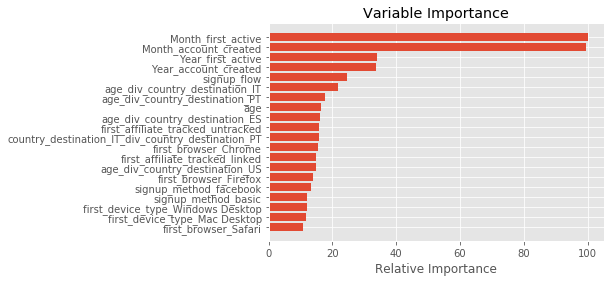

In [89]:
varImpPlot(clf, feature_cols, topN=20, verbose=False)

## 一定の重要度がないものを削除してモデル再構築

In [90]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(feature_cols)
new_feature_cols = feature_cols_ar[feature_importance > 0]

In [101]:
print("# of original feature cols:", len(feature_cols), ", # of new feature cols:",len(new_feature_cols))

# of original feature cols: 183 , # of new feature cols: 173


In [102]:
#予測に用いるデータの再作成
X_train=train[new_feature_cols]
y_train=train.country_destination

In [103]:
X_test=test[new_feature_cols]

In [104]:
X_train_ar = np.array(X_train)
y_train_map_ar = np.array(y_train_map)
X_test_ar = np.array(X_test)

In [105]:
# クロスバリデーション実施
k_fold=KFold(y_train_map_ar.shape[0],5,shuffle=True)
score_list=[]

clf = RandomForestClassifier()

for train_index, test_index in k_fold:
    X1,X2 = X_train_ar[train_index], X_train_ar[test_index]
    Y1,Y2 = y_train_map_ar[train_index], y_train_map_ar[test_index]
    clf.fit(X1, Y1)
    ypred = clf.predict_proba(X2)
    ndcg_score = get_mean_dcg_score(ypred, Y2)
    score_list.append(ndcg_score)

In [106]:
print("Mean: ", np.mean(score_list))
print("SD: ", np.std(score_list))

Mean:  0.786847201476
SD:  0.00143127416402


### うーん、標準偏差は微増したものの、精度が少しばかりあがったので、こちらを採用

## 最終モデルの作成

In [107]:
clf = RandomForestClassifier()
clf.fit(X_train_ar, y_train_map_ar)
ypred_proba = clf.predict_proba(X_test_ar)

## Submission Fileを書き出す

In [108]:
# country_dictのKeyとValueを入れ替えた形で辞書を作る
country_dict_reverse={v:k for k,v in country_dict.items()}
country_dict_reverse

{0: 'ES',
 1: 'GB',
 2: 'IT',
 3: 'CA',
 4: 'PT',
 5: 'DE',
 6: 'AU',
 7: 'other',
 8: 'NL',
 9: 'FR',
 10: 'US',
 11: 'NDF'}

In [109]:
#Submission用データを作成
submission_data = []
for user_id, proba_each in zip(test_id, ypred_proba):
    top5_idx = country_idx[np.argsort(proba_each)][::-1][:5]  #Top5の国のインデックスを取得
    top5_country = [country_dict_reverse[idx] for idx in top5_idx]
    for each_country in top5_country:
        tmp_ = [user_id, each_country]
        submission_data.append(tmp_)

In [110]:
#データフレームに変換
submission_df = pd.DataFrame(submission_data, columns=['id', 'country'])

In [111]:
print(submission_df.shape)
submission_df.head(10)

(310480, 2)


,id,country
0,5uwns89zht,US
1,5uwns89zht,NDF
2,5uwns89zht,FR
3,5uwns89zht,NL
4,5uwns89zht,other
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,IT
9,jtl0dijy2j,FR


In [112]:
#csvファイルに書き出す
submission_df.to_csv("Airbnb_submission.csv",index=False)